In [1]:
from lib import LQG

In [2]:
import numpy as np
from rtree import index
from matplotlib import cm
from matplotlib import pyplot as plt
from scipy import interpolate as interp

In [3]:
GRID_SIZE = 500

In [4]:
def random_unit_vector():
    theta = 2*np.pi*np.random.uniform()
    return np.array([np.sin(theta),np.cos(theta)])

In [5]:
gff = LQG.TorusGFF(GRID_SIZE)

(-0.5, 499.5, 499.5, -0.5)

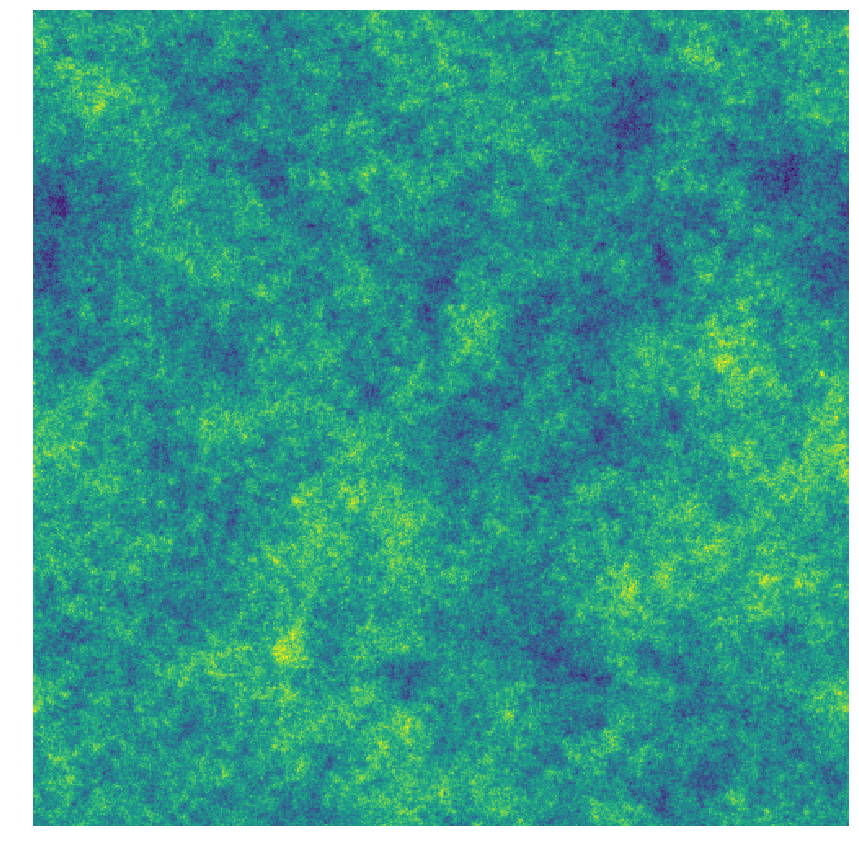

In [6]:
plt.figure(figsize=(15,15))
plt.imshow(gff)
plt.axis('off')
#plt.savefig('gff_colormap.png',dpi=200, bbox_inches='tight')

In [32]:
gamma = 2
lqg_basis = np.exp(gamma*(gff))

def lqg_interpolator(lqg_basis): #Given a discrete LQG; creates a continuous linear interpolatin
    x = np.linspace(0,1,lqg_basis.shape[0])
    interpolator = interp.interp2d(x,x,lqg_basis,fill_value = 1)
    return interpolator

lqg = lqg_interpolator(lqg_basis)

In [33]:
def random_walk_in_LQG(idx, positions, lqg, ball_radius = 1E-5, max_dist=10):
    epsilon = 0.05
    pos = max_dist*random_unit_vector()+np.array([.5,.5]) #start at a random place
    distance = 1000*ball_radius #just initialize the distance to the nearest neigh to a lower bound
    
    def radius(pos):
        return ball_radius/(lqg(*pos)**.5)
    
    closest_object=[0,0]
    
    while distance > radius(pos)+radius(closest_object):

        #update position with allowed jump
        jump = (distance-(1-epsilon)*(radius(pos)+radius(closest_object))) #move knowing that you won't hit
        
        pos += random_unit_vector()*jump
        
              

        #if we drift too far, force come back 
        #(should add a poisson kernel bias, but if we are too far away shouldn't change much)
        dist_from_orig = np.sum(pos**2)**.5 
        if dist_from_orig > 10*max_dist:
            pos = max_dist*random_unit_vector()
            
        # decide how much we should jump next time
        closest_object_id = idx.nearest(tuple(pos)*2, 1).next() # this be the closest object id
        closest_object = positions[closest_object_id] #check the closest object position
        distance = np.sum((pos-closest_object)**2)**.5 #compute the distance to it

    return pos

In [34]:
def DLA_in_LQG(lqg, n_balls = 100, old_balls=[(.5,.5)],ball_radius = 1E-5):
    idx = index.Index()
    
    for ind,ball in enumerate(old_balls): #add all the old balls to the tree
        idx.insert(ind, tuple(ball)*2)
        
    positions = list(old_balls) #copy old_balls to return a fresh array
    max_dist = 2*np.max(np.abs(positions))+4 #just to be sure.. doesn't hurt much

    
    for i in range(len(old_balls),n_balls+len(old_balls)): #to keep the index nice
        if (i%100==0):
            print i,
        new_pos = random_walk_in_LQG(idx, positions, lqg, max_dist = max_dist,ball_radius = ball_radius)
        max_dist = max(max_dist, 2*np.max(np.abs(new_pos))+4) #update the new distance to add incoming balls
        idx.insert(i, tuple(new_pos)*2)
        positions.append(new_pos)

    
    return positions

In [35]:
z=[(.5,.5)]

In [36]:
z = DLA_in_LQG(lqg,old_balls=z,ball_radius = 4E-4,n_balls = 15000);

100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400 14500 14600 14700 14800 14900 15000


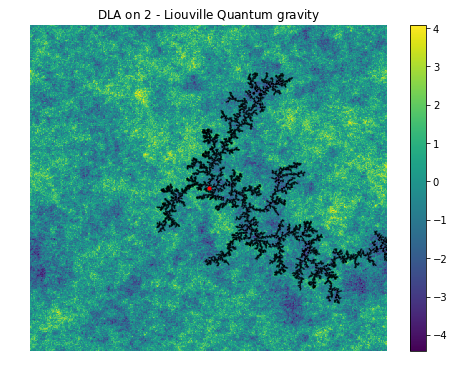

In [38]:

plt.figure(figsize=(8,6))
x0 = np.linspace(0,1,GRID_SIZE)
x_mesh,y_mesh = np.meshgrid(x0,x0)
plt.pcolormesh(x_mesh,y_mesh,1./gamma*np.log(lqg(x0,x0)))
plt.colorbar()

plt.title('DLA on $2$ - Liouville Quantum gravity')

x,y = np.array(z).T
size = np.array([1/lqg(*k)**.5 for k in z])
plt.scatter(x,y,c='k',s=size**2/100., alpha =1)

plt.scatter(x[0],y[0],c='r',s=10)
plt.xlim(0,1)
plt.ylim(0,1)
plt.axis('Off')
plt.savefig('Final_Simulations/2LQG_1DBM.png')


In [13]:
len(z)

5001